In [0]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature
from pyspark.sql import SparkSession
from pyspark.sql.functions import col


In [0]:
# Initialize Spark session
spark = SparkSession.builder.appName("F1ModelDeployment").getOrCreate()

In [0]:
# Loading in F1 Dataset

# Main timing data
df_lap_times = spark.read.csv('s3://columbia-gr5069-main/raw/lap_times.csv', header=True)

# Basic info about races and circuits
df_races = spark.read.csv('s3://columbia-gr5069-main/raw/races.csv', header=True)
df_circuits = spark.read.csv('s3://columbia-gr5069-main/raw/circuits.csv', header=True)

# Driver and constructor (team) information
df_drivers = spark.read.csv('s3://columbia-gr5069-main/raw/drivers.csv', header=True)
df_constructors = spark.read.csv('s3://columbia-gr5069-main/raw/constructors.csv', header=True)

# Convert data types for important columns
df_lap_times = df_lap_times.withColumn("raceId", col("raceId").cast("integer")) \
                        .withColumn("driverId", col("driverId").cast("integer")) \
                        .withColumn("lap", col("lap").cast("integer")) \
                        .withColumn("position", col("position").cast("integer")) \
                        .withColumn("milliseconds", col("milliseconds").cast("integer"))

# Print confirmation
print("F1 dataset loaded successfully")

In [0]:
# Step 1: Create two tables in your own database to store predictions [20 pts]

username = "an3016"  

# Create schema 
spark.sql(f"CREATE SCHEMA IF NOT EXISTS {username}")

# Create first table for Random Forest predictions
rf_table_name = f"{username}.f1_predictions_rf"
spark.sql(f"""
CREATE TABLE IF NOT EXISTS {rf_table_name} (
    prediction_id BIGINT GENERATED ALWAYS AS IDENTITY,
    race_id INT,
    driver_id INT,
    lap INT,
    position INT,
    actual_milliseconds DOUBLE,
    predicted_milliseconds DOUBLE,
    model_version STRING,
    prediction_timestamp TIMESTAMP
)
""")

# Create second table for Gradient Boosting predictions
gb_table_name = f"{username}.f1_predictions_gb"
spark.sql(f"""
CREATE TABLE IF NOT EXISTS {gb_table_name} (
    prediction_id BIGINT GENERATED ALWAYS AS IDENTITY,
    race_id INT,
    driver_id INT,
    lap INT,
    position INT,
    actual_milliseconds DOUBLE,
    predicted_milliseconds DOUBLE,
    model_version STRING,
    prediction_timestamp TIMESTAMP
)
""")

print("Database tables created successfully")

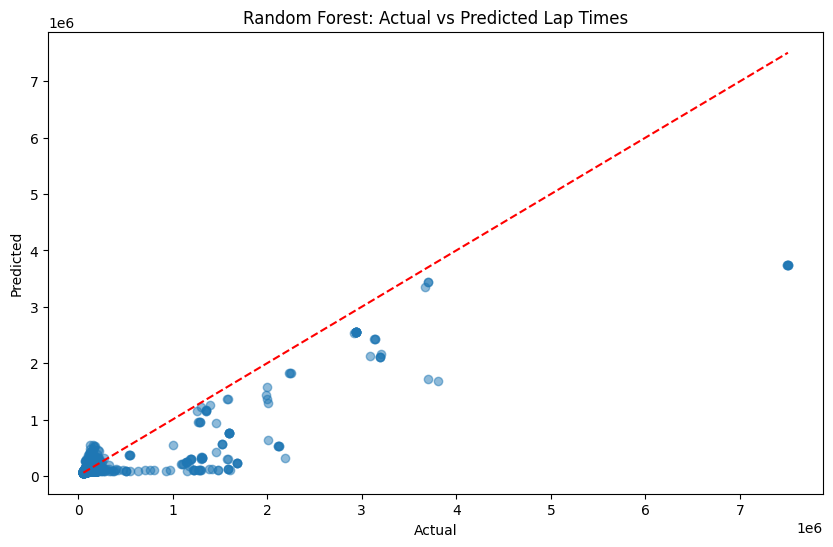

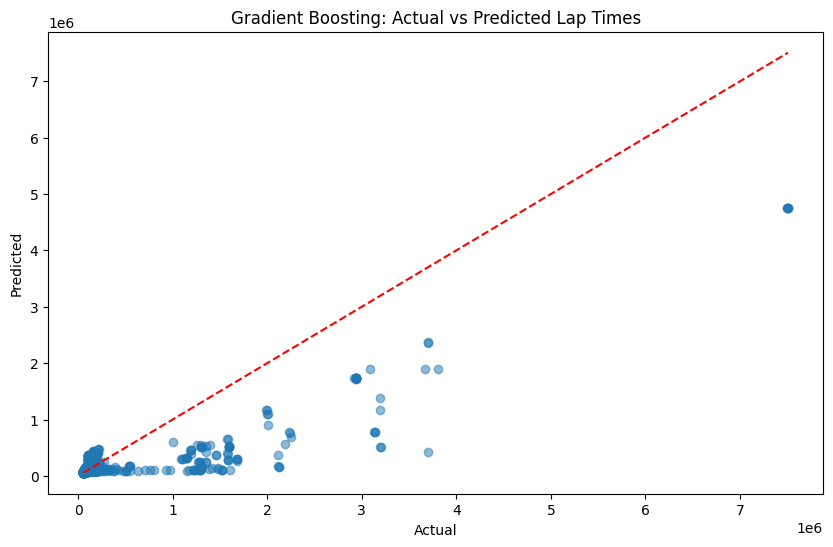

In [0]:
# Step 2: Build two predictive models using MLflow [30 pts]

# Convert Spark DataFrame to Pandas for scikit-learn models
df_lap_times_pd = df_lap_times.toPandas()

# Prepare features and target
X = df_lap_times_pd[['raceId', 'driverId', 'lap', 'position']]
y = df_lap_times_pd['milliseconds']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set the MLflow experiment
mlflow.set_experiment("/Users/an3016@columbia.edu/F1_Model_Deployment") 

# Function to evaluate model
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    r2 = r2_score(actual, pred)
    exp_var = explained_variance_score(actual, pred)
    return rmse, mae, r2, exp_var

# Model 1: Random Forest
with mlflow.start_run(run_name="RandomForest_F1_Model") as run:
    # Define hyperparameters
    n_estimators = 100
    max_depth = 10
    
    # Train the model
    rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    rf.fit(X_train, y_train)
    
    # Make predictions
    predictions_rf = rf.predict(X_test)
    
    # Log metrics
    rmse, mae, r2, exp_var = eval_metrics(y_test, predictions_rf)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("explained_variance", exp_var)
    
    # Log parameters
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("max_depth", max_depth)
    
    # Log model
    signature = infer_signature(X_train, predictions_rf)
    mlflow.sklearn.log_model(rf, "random_forest_model", signature=signature)
    
    # Create artifact 1: Feature importances
    feature_importance = pd.DataFrame(
        {"feature": X_train.columns, "importance": rf.feature_importances_}
    ).sort_values("importance", ascending=False)
    
    # Save feature importances to a temporary file
    feature_importance.to_csv("/tmp/rf_feature_importance.csv", index=False)
    mlflow.log_artifact("/tmp/rf_feature_importance.csv", "feature_importance")
    
    # Create artifact 2: Prediction vs Actual plot
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, predictions_rf, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Random Forest: Actual vs Predicted Lap Times')
    plt.savefig("/tmp/rf_prediction_plot.png")
    mlflow.log_artifact("/tmp/rf_prediction_plot.png", "prediction_plot")
    
    # Save the run ID 
    rf_run_id = run.info.run_id
    print(f"Random Forest model trained and logged with run_id: {rf_run_id}")

# Model 2: Gradient Boosting
with mlflow.start_run(run_name="GradientBoosting_F1_Model") as run:
    # Define hyperparameters
    n_estimators = 100
    learning_rate = 0.1
    max_depth = 5
    
    # Train the model
    gb = GradientBoostingRegressor(
        n_estimators=n_estimators, 
        learning_rate=learning_rate,
        max_depth=max_depth, 
        random_state=42
    )
    gb.fit(X_train, y_train)
    
    # Make predictions
    predictions_gb = gb.predict(X_test)
    
    # Log metrics
    rmse, mae, r2, exp_var = eval_metrics(y_test, predictions_gb)
    mlflow.log_metric("rmse", rmse)
    mlflow.log_metric("mae", mae)
    mlflow.log_metric("r2", r2)
    mlflow.log_metric("explained_variance", exp_var)
    
    # Log parameters
    mlflow.log_param("n_estimators", n_estimators)
    mlflow.log_param("learning_rate", learning_rate)
    mlflow.log_param("max_depth", max_depth)
    
    # Log model
    signature = infer_signature(X_train, predictions_gb)
    mlflow.sklearn.log_model(gb, "gradient_boosting_model", signature=signature)
    
    # Create artifact 1: Feature importances
    feature_importance = pd.DataFrame(
        {"feature": X_train.columns, "importance": gb.feature_importances_}
    ).sort_values("importance", ascending=False)
    
    # Save feature importances to a temporary file
    feature_importance.to_csv("/tmp/gb_feature_importance.csv", index=False)
    mlflow.log_artifact("/tmp/gb_feature_importance.csv", "feature_importance")
    
    # Create artifact 2: Prediction vs Actual plot
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, predictions_gb, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Gradient Boosting: Actual vs Predicted Lap Times')
    plt.savefig("/tmp/gb_prediction_plot.png")
    mlflow.log_artifact("/tmp/gb_prediction_plot.png", "prediction_plot")
    
    # Save the run ID 
    gb_run_id = run.info.run_id
    print(f"Gradient Boosting model trained and logged with run_id: {gb_run_id}")

print("Models built and logged successfully")

In [0]:
%python
from datetime import datetime

# Step 3: Store model predictions in your database tables [30 pts]

username = "an3016"  
rf_table_name = f"{username}.f1_predictions_rf"
gb_table_name = f"{username}.f1_predictions_gb"

print("Schema of the Random Forest predictions table:")
spark.sql(f"DESCRIBE {rf_table_name}").show()

# Create properly structured DataFrames 
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType, StringType, TimestampType

# Define the schema 
prediction_schema = StructType([
    StructField("race_id", IntegerType(), False),
    StructField("driver_id", IntegerType(), False),
    StructField("lap", IntegerType(), False),
    StructField("position", IntegerType(), False),
    StructField("actual_milliseconds", DoubleType(), False),
    StructField("predicted_milliseconds", DoubleType(), False),
    StructField("model_version", StringType(), False),
    StructField("prediction_timestamp", TimestampType(), False)
])

# Create DataFrames 
# Random Forest predictions
rf_predictions_data = [(
    int(row['raceId']), 
    int(row['driverId']), 
    int(row['lap']), 
    int(row['position']),
    float(actual),
    float(pred),
    rf_run_id,
    datetime.now()
) for row, actual, pred in zip(X_test.to_dict('records'), y_test, predictions_rf)]

spark_predictions_rf = spark.createDataFrame(rf_predictions_data, schema=prediction_schema)

# Gradient Boosting predictions
gb_predictions_data = [(
    int(row['raceId']), 
    int(row['driverId']), 
    int(row['lap']), 
    int(row['position']),
    float(actual),
    float(pred),
    gb_run_id,
    datetime.now()
) for row, actual, pred in zip(X_test.to_dict('records'), y_test, predictions_gb)]

spark_predictions_gb = spark.createDataFrame(gb_predictions_data, schema=prediction_schema)

# Write predictions to the database tables using INSERT INTO instead of saveAsTable
# For Random Forest predictions
rf_insert_query = f"""
INSERT INTO {rf_table_name} (race_id, driver_id, lap, position, actual_milliseconds, 
                           predicted_milliseconds, model_version, prediction_timestamp)
SELECT race_id, driver_id, lap, position, actual_milliseconds, 
       predicted_milliseconds, model_version, prediction_timestamp
FROM temp_rf_predictions
"""

# Register temporary view
spark_predictions_rf.createOrReplaceTempView("temp_rf_predictions")

# Execute insert
spark.sql(rf_insert_query)
print(f"Stored {spark_predictions_rf.count()} Random Forest predictions")

# For Gradient Boosting predictions
gb_insert_query = f"""
INSERT INTO {gb_table_name} (race_id, driver_id, lap, position, actual_milliseconds, 
                           predicted_milliseconds, model_version, prediction_timestamp)
SELECT race_id, driver_id, lap, position, actual_milliseconds, 
       predicted_milliseconds, model_version, prediction_timestamp
FROM temp_gb_predictions
"""

# Register temporary view
spark_predictions_gb.createOrReplaceTempView("temp_gb_predictions")

# Execute insert
spark.sql(gb_insert_query)
print(f"Stored {spark_predictions_gb.count()} Gradient Boosting predictions")

# Verify that the data was written correctly
rf_count = spark.sql(f"SELECT COUNT(*) FROM {rf_table_name}").collect()[0][0]
gb_count = spark.sql(f"SELECT COUNT(*) FROM {gb_table_name}").collect()[0][0]

print(f"Random Forest predictions table contains {rf_count} rows")
print(f"Gradient Boosting predictions table contains {gb_count} rows")

# Show sample data from each table
print("\nSample of Random Forest predictions:")
display(spark.sql(f"SELECT * FROM {rf_table_name} LIMIT 5"))

print("\nSample of Gradient Boosting predictions:")
display(spark.sql(f"SELECT * FROM {gb_table_name} LIMIT 5"))

print("\nStep 3 completed successfully!")

prediction_id,race_id,driver_id,lap,position,actual_milliseconds,predicted_milliseconds,model_version,prediction_timestamp
1,879,5,17,16,86697.0,100909.54125469776,1f81e659429c4259a9c043f65dbf597e,2025-04-26T22:04:27.803787Z
5,125,8,23,2,99946.0,88753.9021504164,1f81e659429c4259a9c043f65dbf597e,2025-04-26T22:04:27.803796Z
9,64,18,43,6,77872.0,78407.09993750525,1f81e659429c4259a9c043f65dbf597e,2025-04-26T22:04:27.8038Z
13,989,817,42,4,86872.0,94596.51210705355,1f81e659429c4259a9c043f65dbf597e,2025-04-26T22:04:27.803804Z
17,188,57,17,2,83787.0,100135.33662941941,1f81e659429c4259a9c043f65dbf597e,2025-04-26T22:04:27.803807Z


prediction_id,race_id,driver_id,lap,position,actual_milliseconds,predicted_milliseconds,model_version,prediction_timestamp
1,879,5,17,16,86697.0,101772.07234872442,9bc3852957924b7f8231a7a91f9ee1d5,2025-04-26T22:04:37.629562Z
5,125,8,23,2,99946.0,87897.66701051705,9bc3852957924b7f8231a7a91f9ee1d5,2025-04-26T22:04:37.629572Z
9,64,18,43,6,77872.0,83701.48689665599,9bc3852957924b7f8231a7a91f9ee1d5,2025-04-26T22:04:37.629575Z
13,989,817,42,4,86872.0,96767.86042481067,9bc3852957924b7f8231a7a91f9ee1d5,2025-04-26T22:04:37.629579Z
17,188,57,17,2,83787.0,92299.03209310907,9bc3852957924b7f8231a7a91f9ee1d5,2025-04-26T22:04:37.629582Z
